## Importing Common Libs

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import torch 
import json
import sys
import torch
import torch.nn.functional as F
import os
import numpy as np

sys.path.append("src")
os.chdir('/home/george-vengrovski/Documents/projects/tweety_bert_paper')

from data_class import SongDataSet_Image, CollateFunction
from model import TweetyBERT
from analysis import plot_umap_projection
from utils import detailed_count_parameters, load_weights, load_model

/home/george-vengrovski/anaconda3/envs/canary-vae/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torch.utils.data import DataLoader
from data_class import SongDataSet_Image

train_dir = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/files/llb3_train"
test_dir = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/files/llb3_test"

train_dataset = SongDataSet_Image(train_dir, num_classes=21, psuedo_labels_generated=False)
test_dataset = SongDataSet_Image(test_dir, num_classes=21, psuedo_labels_generated=False)

collate_fn = CollateFunction(segment_length=1000)  # Adjust the segment length if needed

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

## UMAP 

/home/george-vengrovski/anaconda3/envs/canary-vae/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


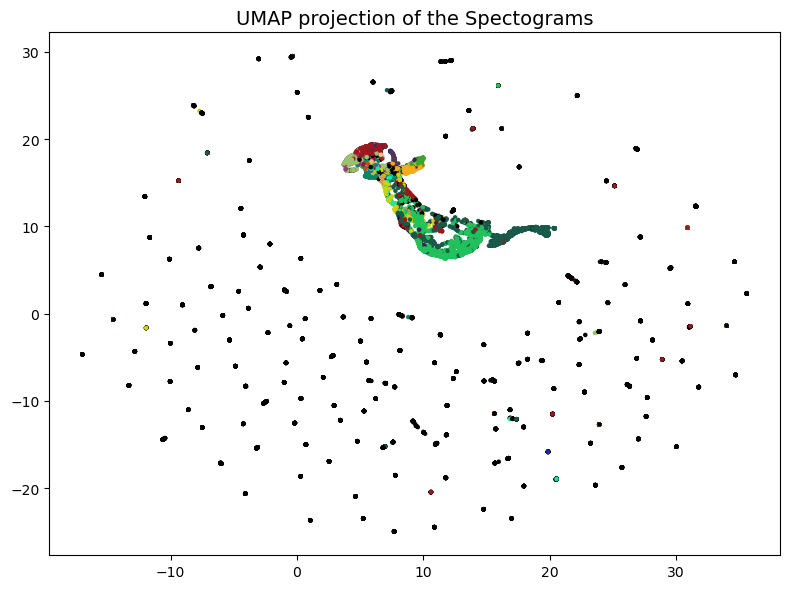

In [12]:
reductions_dims = 2
plot_figure = True 

import pickle 
import umap

list_of_data = []
list_of_ground_truth = []

for i,  (data, ground_truth_label, _) in enumerate(train_loader):
    # remove channel dim (used for conv)
    data = data[:,0,:,:]
    data = data.permute(0,2,1)
    ground_truth_label = ground_truth_label.argmax(-1)
    data = data.cpu().numpy()
    ground_truth_label = ground_truth_label.cpu().numpy()
    ground_truth_label = ground_truth_label.reshape(-1,1)
    data = data.reshape(-1,1 * 196)
    list_of_data.append(data)
    list_of_ground_truth.append(ground_truth_label)

    if i > 100:
        break

# Concatenate the lists
list_of_data = np.concatenate(list_of_data, axis=0)
list_of_ground_truth = np.concatenate(list_of_ground_truth, axis=0)

# Randomly sample 10,000 points
sample_indices = np.random.choice(list_of_data.shape[0], 10000, replace=False)
list_of_data_sampled = list_of_data[sample_indices]
list_of_ground_truth_sampled = list_of_ground_truth[sample_indices]


# color stuff #
file_path = "/home/george-vengrovski/Documents/projects/tweety_bert_cluster/project/category_colors_llb3.pkl"
with open(file_path, 'rb') as file:
    color_map_data = pickle.load(file)

label_to_color = {label: tuple(color) for label, color in color_map_data.items()}

colors_for_points = []
for label_row in list_of_ground_truth_sampled:
    if label_row.ndim > 0:
        # If label_row is iterable (more than one dimension)
        row_colors = [label_to_color[int(lbl)] for lbl in label_row]
        avg_color = np.mean(row_colors, axis=0)
    else:
        # If label_row is a single integer (one dimension)
        avg_color = label_to_color[int(label_row)]
    colors_for_points.append(avg_color)


# UMAP reduction
reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.05, n_components=reductions_dims, metric='euclidean')
embedding_outputs = reducer.fit_transform(list_of_data_sampled)

# Plotting (if conditions are met)
if reductions_dims == 2 and plot_figure == True:
    # Create the plot
    fig = plt.figure(figsize=(8, 6))
    plt.scatter(embedding_outputs[:, 0], embedding_outputs[:, 1], s=5, c=colors_for_points)
    plt.title('UMAP projection of the Spectograms', fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
from linear_probe import LinearProbeModel, LinearProbeTrainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier_model = LinearProbeModel(num_classes=21, model_type="umap", model=reducer, freeze_layers=True, layer_num=-1, layer_id="feed_forward_output_relu", classifier_dims=2)
classifier_model = classifier_model.to(device)


In [ ]:
trainer = LinearProbeTrainer(model=classifier_model, train_loader=train_loader, test_loader=test_loader, device=device, lr=1e-3, plotting=True, batches_per_eval=1, desired_total_batches=5, patience=8)
trainer.train()

In [ ]:
from linear_probe import ModelEvaluator

evaluator = ModelEvaluator(classifier_model, test_loader)
class_frame_error_rates, total_frame_error_rate = evaluator.validate_model_multiple_passes(num_passes=1, max_batches=1250)
evaluator.save_results(class_frame_error_rates, total_frame_error_rate, 'results')

## PCA Plot Visual Inspection (Not needed for later steps)

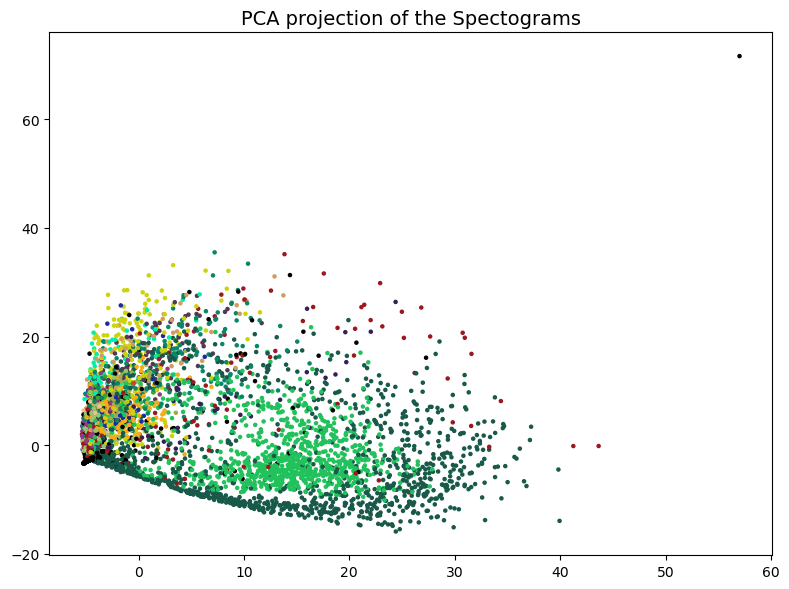

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pickle

reductions_dims = 2
plot_figure = True

list_of_data = []
list_of_ground_truth = []

for i, (data, ground_truth_label, _) in enumerate(test_loader):
    # Remove channel dimension (used for convolutional layers)
    data = data[:, 0, :, :]
    # Permute dimensions
    data = data.permute(0, 2, 1)
    # Convert labels to indices
    ground_truth_label = ground_truth_label.argmax(-1)
    # Convert to numpy arrays
    data = data.cpu().numpy()
    ground_truth_label = ground_truth_label.cpu().numpy()
    # Reshape labels
    ground_truth_label = ground_truth_label.reshape(-1, 1)
    data = data.reshape(-1, 1 * 196)
    # Append to lists
    list_of_data.append(data)
    list_of_ground_truth.append(ground_truth_label)

    # Break the loop after processing 101 batches
    if i > 100:
        break

# Concatenate the lists
list_of_data = np.concatenate(list_of_data, axis=0)
list_of_ground_truth = np.concatenate(list_of_ground_truth, axis=0)

# Randomly sample 10,000 points
sample_indices = np.random.choice(list_of_data.shape[0], 10000, replace=False)
list_of_data_sampled = list_of_data[sample_indices]
list_of_ground_truth_sampled = list_of_ground_truth[sample_indices]

# Load color map data
file_path = "/home/george-vengrovski/Documents/projects/tweety_bert_cluster/project/category_colors_llb3.pkl"
with open(file_path, 'rb') as file:
    color_map_data = pickle.load(file)

# Map labels to colors
label_to_color = {label: tuple(color) for label, color in color_map_data.items()}

# Prepare colors for plotting points
colors_for_points = []
for label_row in list_of_ground_truth_sampled:
    if label_row.ndim > 0:
        row_colors = [label_to_color[int(lbl)] for lbl in label_row]
        avg_color = np.mean(row_colors, axis=0)
    else:
        avg_color = label_to_color[int(label_row)]
    colors_for_points.append(avg_color)

# Initialize and apply PCA
pca = PCA(n_components=reductions_dims, random_state=42)
embedding_outputs = pca.fit_transform(list_of_data_sampled)

# Plot if conditions are met
if reductions_dims == 2 and plot_figure == True:
    fig = plt.figure(figsize=(8, 6))
    plt.scatter(embedding_outputs[:, 0], embedding_outputs[:, 1], s=5, c=colors_for_points)
    plt.title('PCA projection of the Spectograms', fontsize=14)
    plt.tight_layout()
    plt.show()


In [8]:
from linear_probe import LinearProbeModel, LinearProbeTrainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier_model = LinearProbeModel(num_classes=21, model_type="pca", model=None, freeze_layers=None, layer_num=None, layer_id=None, classifier_dims=2)
classifier_model = classifier_model.to(device)

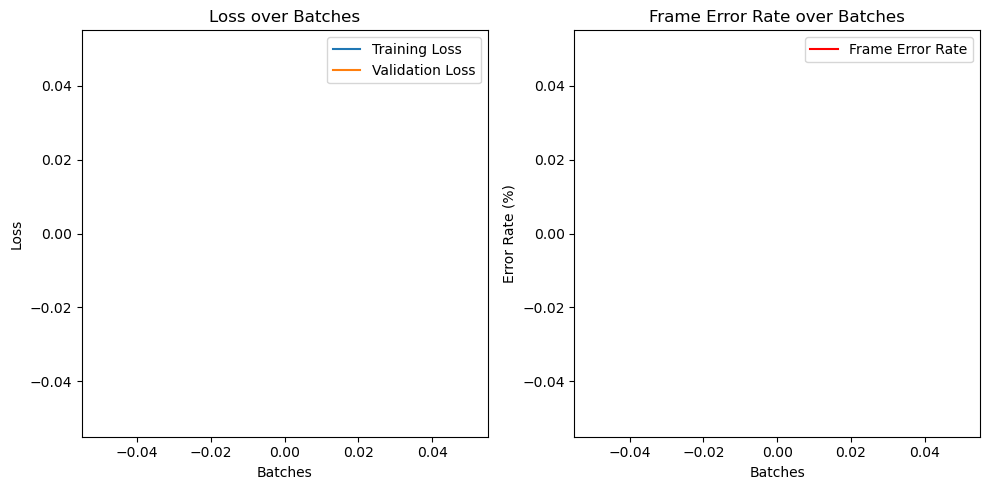

In [7]:
trainer = LinearProbeTrainer(model=classifier_model, train_loader=train_loader, test_loader=test_loader, device=device, lr=1e-3, plotting=True, batches_per_eval=100, desired_total_batches=1, patience=4)
trainer.train()

In [9]:
from linear_probe import ModelEvaluator

evaluator = ModelEvaluator(classifier_model, test_loader, use_tqdm=True)
class_frame_error_rates, total_frame_error_rate = evaluator.validate_model_multiple_passes(num_passes=1, max_batches=1250)
evaluator.save_results(class_frame_error_rates, total_frame_error_rate, 'results')

Evaluating: 100%|██████████| 133/133 [00:17<00:00,  7.48batch/s]


## Raw Spectogram

In [6]:
from linear_probe import LinearProbeModel, LinearProbeTrainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier_model = LinearProbeModel(num_classes=21, model_type="raw", model=None, freeze_layers=None, layer_num=None, layer_id=None, classifier_dims=196)
classifier_model = classifier_model.to(device)

Batch 100: FER = 58.83%, Train Loss = 2.3492, Val Loss = 2.4090
Batch 200: FER = 51.31%, Train Loss = 1.9580, Val Loss = 2.0564
Batch 300: FER = 50.25%, Train Loss = 1.8185, Val Loss = 1.9596
Batch 400: FER = 50.90%, Train Loss = 1.9549, Val Loss = 1.9072
Batch 500: FER = 49.84%, Train Loss = 2.0577, Val Loss = 1.9208
Batch 600: FER = 49.06%, Train Loss = 1.8103, Val Loss = 1.9497
Batch 700: FER = 50.24%, Train Loss = 2.3451, Val Loss = 1.9686
Batch 800: FER = 52.57%, Train Loss = 1.9042, Val Loss = 1.9810
Early stopping triggered


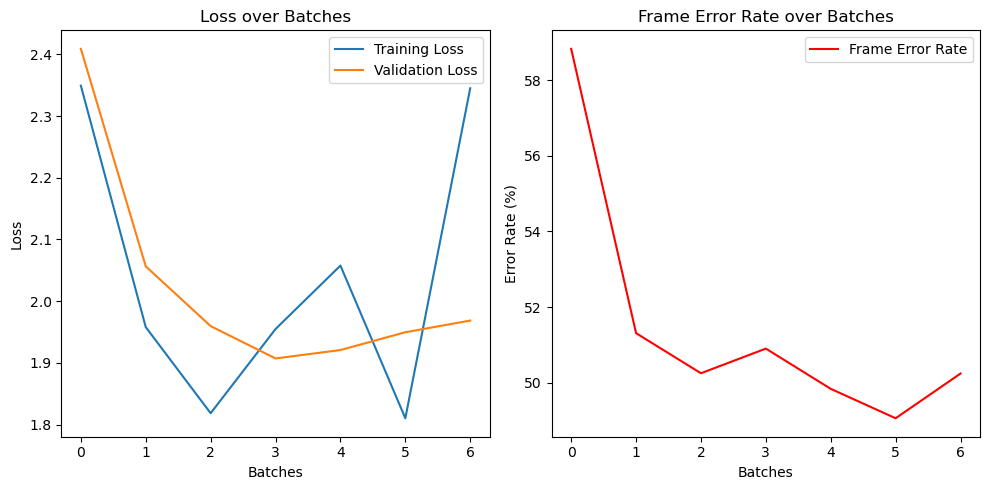

In [7]:
trainer = LinearProbeTrainer(model=classifier_model, train_loader=train_loader, test_loader=test_loader, device=device, lr=1e-3, plotting=True, batches_per_eval=100, desired_total_batches=1e4, patience=4)
trainer.train()

In [8]:
from linear_probe import ModelEvaluator

evaluator = ModelEvaluator(classifier_model, test_loader, use_tqdm=True)
class_frame_error_rates, total_frame_error_rate = evaluator.validate_model_multiple_passes(num_passes=1, max_batches=1250)
evaluator.save_results(class_frame_error_rates, total_frame_error_rate, 'results')

Evaluating: 100%|██████████| 133/133 [00:16<00:00,  8.04batch/s]


## SAP Factors

## AVES

In [10]:
from torchaudio.models import wav2vec2_model

class AvesTorchaudioWrapper(nn.Module):
    def __init__(self, config_path, model_path):
        super().__init__()

        # reference: https://pytorch.org/audio/stable/_modules/torchaudio/models/wav2vec2/utils/import_fairseq.html

        self.config = self.load_config(config_path)
        self.model = wav2vec2_model(**self.config, aux_num_out=None)
        self.model.load_state_dict(torch.load(model_path))
        self.model.feature_extractor.requires_grad_(False)

    def load_config(self, config_path):
        with open(config_path, 'r') as ff:
            obj = json.load(ff)

        return obj

    def forward(self, sig):
        # extract_feature in the sorchaudio version will output all 12 layers' output, -1 to select the final one
        out = self.model.extract_features(sig)[0][-1]

        return out

model_path = "/home/george-vengrovski/Documents/data/AVES Data/aves-base-all.torchaudio.pt"
config_path = "/home/george-vengrovski/Documents/data/AVES Data/aves-base-all.torchaudio.model_config.json"
test_song = ""

torchaudio_model = AvesTorchaudioWrapper(config_path, model_path)
torchaudio_model.eval()


AvesTorchaudioWrapper(
  (model): Wav2Vec2Model(
    (feature_extractor): FeatureExtractor(
      (conv_layers): ModuleList(
        (0): ConvLayerBlock(
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        )
        (1-4): 4 x ConvLayerBlock(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        )
        (5-6): 2 x ConvLayerBlock(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        )
      )
    )
    (encoder): Encoder(
      (feature_projection): FeatureProjection(
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (projection): Linear(in_features=512, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (pos_conv_embed): ConvolutionalPositionalEmbedding(
          (conv): ParametrizedConv1d(
            768, 768